In [4]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
from skimage import feature
from scipy import ndimage as ndi
import cv2
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from scipy.interpolate import interp2d
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import warnings
import math
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.interpolate import splev,splrep
from operator import itemgetter 
from math import sqrt
warnings.filterwarnings('ignore')

In [5]:
path = 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/longrods.mat' # replace with wherever you save the file
data = loadmat(path)

In [6]:
def findCircle(x1, y1, x2, y2, x3, y3) : 
    x12 = x1 - x2;  
    x13 = x1 - x3;  
  
    y12 = y1 - y2;  
    y13 = y1 - y3;  
  
    y31 = y3 - y1;  
    y21 = y2 - y1;  
  
    x31 = x3 - x1;  
    x21 = x2 - x1;  
  
    # x1^2 - x3^2  
    sx13 = pow(x1, 2) - pow(x3, 2);  
  
    # y1^2 - y3^2  
    sy13 = pow(y1, 2) - pow(y3, 2);  
  
    sx21 = pow(x2, 2) - pow(x1, 2);  
    sy21 = pow(y2, 2) - pow(y1, 2);  
  
    f = (((sx13) * (x12) + (sy13) * 
          (x12) + (sx21) * (x13) + 
          (sy21) * (x13)) // (2 * 
          ((y31) * (x12) - (y21) * (x13)))); 
              
    g = (((sx13) * (y12) + (sy13) * (y12) + 
          (sx21) * (y13) + (sy21) * (y13)) // 
          (2 * ((x31) * (y12) - (x21) * (y13))));  
  
    c = (-pow(x1, 2) - pow(y1, 2) - 
         2 * g * x1 - 2 * f * y1);  
  
    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0  
    # where centre is (h = -g, k = -f) and  
    # radius r as r^2 = h^2 + k^2 - c  
    h = -g;  
    k = -f;  
    sqr_of_r = h * h + k * k - c;  
  
    # r is the radius  
    r = round(sqrt(sqr_of_r), 5);  
    # print(type(r))
    # print("Centre = (", h, ", ", k, ")");  
    curvature = round(1/r, 4)
    if np.isnan(curvature) == True:
        curvature = 0
    return curvature 

In [41]:
def determine_tip_and_curvature(particle, blur=(4,4), pixel_to_nm_ratio = 1, show_plot = True, print_output = True, ylim_plots = [0,100]): 
    """ 
    This function takes an inputted nanorod image (defined in pixels), computes the edge, determines the locations of the 
    tips and calculates the curvature at each point. 
    Parameters
    ----------
    particle : ndarray
        The image of the particle. Must be oriented so the horizontal axis is parallel to the long axis of the rod (if this is 
        and issue let me know and I can include a function that should be able to orient the rods correctly)
    Returns
    -------
    list of lists: 
    first entry: 
        smoothed xs (first entry) and ys (second entry) of the inputted rod in pixels if pixel_to_nm_ratio is not specified
    second entry: 
        xs (first entry) and ys (second entry) used to calculate curvature, and the calculated curvature at each point 
        (third entry)
    third entry: 
        rod diameters (first and second entries), tip lengths (third and fourth entries) and tip to diameter ratios (fifth and 
        sixth entries) for the right and left tips, respectively 
    fourth entry: 
        total area of the rod (first entry) total area taken up by the tips (both tips combined, second entry) and the tip area
        divided by the total area (third entry)
    fifth entry: 
        average curvatures of the right (first entry) and left (second entry) tips 
    """
    # uncomment to plot the inputted particle
    # plt.imshow(particle)
    # plt.show()
    
    blurred = cv2.blur(particle, blur) # blurs the particle so the edges can be extracted
    
    # uncomment to plot the particle after blurring if you want to see what the blurring does
    #plt.imshow(blurred)
    #plt.show()
    
    edges = blurred - ndi.morphology.binary_dilation(blurred) # this is how the edge of the particle is extracted 
    pixels = np.argwhere(edges == 255) 
    x = (pixels[:, 1])
    y = (pixels[:, 0])
    
    # uncomment to show the edge of the particle post extraction 
    # plt.imshow(edges, cmap = plt.cm.gray)
    # plt.show()
    
    # uncomment to show the edge of the particle post conversion to a scatter plot. converting the image to a list of x and y 
    # points is how the tips are eventually extracted 
    # plt.scatter(x,y, s=1)
    # plt.show()
    
    # this is a hacked together solution to some problems involving converting pixels to points we can easily interpolate. I 
    # can go into more detail here if it looks like something in here is causing problems, but otherwise best to treat it like 
    # a black box. The issue is a little tricky to explain in words, but if you uncomment the plotting code below and compare to 
    # the scatter plot a couple lines above, it will be obvious what the problem is
    
    #plt.plot(x,y)
    #plt.show()
    
    points = np.vstack((x,y))
    points_t = points.T
    sorted_points = sorted(points_t,key=lambda x: x[0])
    sorted_points.reverse()
        
    new_x = [sorted_points[0][0]]
    new_y = [sorted_points[0][1]]
    temp_x = []
    temp_y = []
    x_val = sorted_points[0][0]
    for i in range(1, len(sorted_points)):
    #if sorted_points[i][0] < x_val:
        #x_val = sorted_points[i][0]
        #new_y.reverse()
        if sorted_points[i][1] == new_y[len(new_y)-1] - 1 or sorted_points[i][1] == new_y[len(new_y)-1]:
            new_x.append(sorted_points[i][0])
            new_y.append(sorted_points[i][1])
        
        elif sorted_points[i][1] < new_y[len(new_y)-1] + 10:
            new_x.append(sorted_points[i][0])
            new_y.append(sorted_points[i][1])
        else: 
            temp_x.append(sorted_points[i][0])
            temp_y.append(sorted_points[i][1])
        
    new_points = np.vstack((new_x, new_y)).T
    new_points_temp = np.vstack((temp_x, temp_y)).T
    flipped = np.flip(new_points_temp)
    flipped_final = np.vstack((flipped.T[1], flipped.T[0])).T
    new_points = np.append(new_points, flipped_final, axis = 0)
    

    # Compare the plot below to the plot at the start of this section to understand what this block has done
    # plt.plot(new_points.T[0], new_points.T[1], color = 'r')
    # plt.show()
    
    # empty lists that will hold information about the tips 
    tip_points = []
    
    # This chunk of code smooths the edges of the rod by average the 6 nearest neighbors to each point (3 in front and 3 behind)
    # with that point's value to determine the "smoothed" value for that point. At 6 nearest neighbors it's not doing a ton
    # but I've decided to err on the side of being less smoothed rather than risking failinig to mis represent the rod, since the 
    # regions of high curvature, ie the starts and ends of the tips, will be the first to get messed up. 
    # TODO add a way to change the number of averaged points from the function's parameters
    points = np.arange(0, len(new_points.T[0]), 1)
    new_xs = []
    new_ys = []
    for i in points:
        start = i-3
        end = i+3
        points_temp_x = []
        points_temp_y = []
        if start >= 0 and end <= len(new_points.T[0]) - 3:
            for j in range(start, end+1):
                points_temp_x.append(new_points.T[0][j])
                points_temp_y.append(new_points.T[1][j])
        if start < 0: # makes sure the averaging wraps around to the end of the list if averaging an early point
            points_list = []
            new_start = len(new_points.T[0]) + start 
            for k in range(new_start, len(new_points.T[0])):
                points_list.append(k)
            for k in range(0, end):
                points_list.append(k)
            for j in points_list:
                points_temp_x.append(new_points.T[0][j])
                points_temp_y.append(new_points.T[1][j])
        if end > len(new_points.T[0]) - 3: # wraps to the begining if averaging a point towards the end of the list
            points_list = []
            new_end = end - (len(new_points.T[0]) - 3)
            for k in range(start, len(new_points.T[0])):
                points_list.append(k)
            for k in range(0, new_end):
                points_list.append(k)
            for j in points_list:
                points_temp_x.append(new_points.T[0][j])
                points_temp_y.append(new_points.T[1][j])
        new_point_x = np.mean(points_temp_x)
        new_point_y = np.mean(points_temp_y)
        
        new_xs.append(new_point_x) # new_xs and new_ys contain the smoothed points. Should be the same length as the unsmoothed points
        new_ys.append(new_point_y)
        
    
    # plt.plot(*new_points.T, color = 'k', linestyle = '-', label='original rod', linewidth = 3);
    # plt.plot(new_xs, new_ys, 'r')
    # plt.show()
    
    new_xs = np.asarray(new_xs)/pixel_to_nm_ratio # divide the points by the ratio of pixels to nm for the TEM. 
    # Defaults to 1 if none is provided, keeping the units as pixels
    new_ys = np.asarray(new_ys)/pixel_to_nm_ratio

    
    # calculate the curvature around the rod. This code reduces the number of points for ease of viewing and preventing large noise
    # spikes from determining curvature. Additionally, it calculates the curvature at a point by fitting a circle to that point 
    # and the points two indicies ahead and behind. I have found that this works best to avoid situations where one curvature 
    # is randomly way higher than the others (which is usually caused by a noise region). Feel free to change this approach or 
    # reach out to me if you find it's producing weird results for any of the literature rods. I suspect we will have to change a
    # couple things early on to account for the differences in resolution etc 
    curvature_points = np.arange(3, len(new_xs)-3, 7)
    new_xs_curvature = [] # holds the x points where curvature has been calculated. This will be 1/7th of the total points, since 
    # in this approach I'm averaging a point with its 6 nearest neighbors and then not including the nearest neighbors, different 
    # than the smoothing step above. 
    new_ys_curvature = []
    for i in curvature_points:
        start = i-3
        end = i+3
        points_temp_x = []
        points_temp_y = []
        for j in range(start, end+1):
            points_temp_x.append(new_xs[j])
            points_temp_y.append(new_ys[j])
        new_point_x = np.mean(points_temp_x)
        new_point_y = np.mean(points_temp_y)
        new_xs_curvature.append(new_point_x)
        new_ys_curvature.append(new_point_y)
    
    
    # now actually calculate the curvatures. For the points that have nearest neighbors on opposite ends of the list I was lazy 
    # and just put that in manually, TODO automate this 
    curvatures = []
    curvatures.append(findCircle(new_xs_curvature[len(new_ys_curvature)-3], new_ys_curvature[len(new_ys_curvature)-3], 
                                 new_xs_curvature[len(new_ys_curvature)-1], new_ys_curvature[len(new_ys_curvature)-1], 
                                 new_xs_curvature[1], new_ys_curvature[1]))
    curvatures.append(findCircle(new_xs_curvature[len(new_ys_curvature)-2], new_ys_curvature[len(new_ys_curvature)-2], 
                                 new_xs_curvature[0], new_ys_curvature[0], new_xs_curvature[2], new_ys_curvature[2]))
    for i in range(2, len(new_xs_curvature)-2): 
        points = [i-2, i, i+2] # curvature is between second nearest neighbors 
        circle_xs = []
        circle_ys = []
        for point in points: 
            x = new_xs_curvature[point]
            y = new_ys_curvature[point]
            circle_xs.append(x)
            circle_ys.append(y)
        curvatures.append(findCircle(circle_xs[0], circle_ys[0],circle_xs[1], circle_ys[1],circle_xs[2], circle_ys[2])) # calls 
        # the findCircle function defined above 
        
    curvatures.append(findCircle(new_xs_curvature[len(new_xs_curvature)-5], new_ys_curvature[len(new_ys_curvature)-4], 
                                 new_xs_curvature[len(new_xs_curvature)-3], new_ys_curvature[len(new_ys_curvature)-3],
                                 new_xs_curvature[len(new_xs_curvature)-1], new_ys_curvature[len(new_xs_curvature)-1]))
    
    curvatures.append(findCircle(new_xs_curvature[len(new_xs_curvature)-4], new_ys_curvature[len(new_ys_curvature)-4], 
                                 new_xs_curvature[len(new_xs_curvature)-2], new_ys_curvature[len(new_ys_curvature)-2],
                                 new_xs_curvature[0], new_ys_curvature[0]))
    

    derivs = np.abs(np.gradient(new_ys, new_xs)) # calculate dy/dx at each point 
    min_x = min(new_xs)
    max_x = max(new_xs)
    
    max_x_index = list(new_xs).index(max_x) # finds the index of the max and min x point in the rod. This is used to determine 
    # where the tip finding code should start
    min_x_index = list(new_xs).index(min_x)
    
    
    
    for i in range(max_x_index, len(derivs)):# first tip point is the bottom right corner of the rod. Start at the point of the tip
        # and find the point where the derivative of the rod's shape starts to approach zero. Add to a list containing the 
        # locations that will build the tips. TODO At some point we may want to try and figure out a way to determine what 
        # the derivative threshold should be based on the list of derivaties for a particular rod. Right now, I've put in an
        # arbitrary threshold that seems to be working well, but this could change with literature TEMs 
        # print(derivs[i], new_xs[i], new_ys[i])
        if derivs[i] < 0.2 and tip_points == []: 
            if derivs[i+1]/10 < derivs[i]: # I put this in because sometimes random points are very small in this region for some
                # reason, even if they're right in the middle of the tip. So the code checks if the next point has a derivative 
                # much higher than the current point before it calls that the end of the tip 
                tip_points.append([new_xs[i], new_ys[i]])



    for i in np.linspace(max_x_index, -len(derivs), (max_x_index + len(derivs) + 1)):  # same deal here with the top right
        # corner of the rod. 
        i = int(i)
        if i < 0:
            i = len(derivs) + i
        if derivs[i] < 0.2 and len(tip_points) == 1: 
            if i != 0:
                tip_points.append([new_xs[i], new_ys[i]])




    for i in np.linspace(min_x_index, len(derivs)-1, (len(derivs) - min_x_index)): # This block finds the tip for the top 
        # left corner of the rod
        i = int(i)
        # print(i)
        # print([new_xs[i], new_ys[i]])
        if derivs[i] < 0.2 and len(tip_points) == 2:
            if i != 0:
                tip_points.append([new_xs[i], new_ys[i]])


                    
    for i in np.linspace(min_x_index, 0, (min_x_index + 1)):  # This block finds the tip for the bottom 
        # left corner of the rod
        i = int(i)
        # print(i)
        # print([new_xs[i], new_ys[i]])
        if derivs[i] < 0.2 and len(tip_points) == 3:
            if i != 0:
                tip_points.append([new_xs[i], new_ys[i]])

          
                    
    
    min_y = min(new_ys)
    max_y = max(new_ys)
    avg_y = (min(new_ys) + max(new_ys))/2
    if show_plot == True: 
        plt.plot(new_points.T[0]/pixel_to_nm_ratio, new_points.T[1]/pixel_to_nm_ratio, 'k', linewidth = 3, label = 'original rod')
        plt.plot(new_xs, new_ys, 'orange', label = 'smoothed rod')
        plt.ylim(ylim_plots)

    if tip_points != []:
        if len(tip_points) == 4:
            if show_plot == True:
                plt.plot([tip_points[0][0],tip_points[1][0]], [tip_points[0][1],tip_points[1][1]], label = "rod diameter", color = 'b')
                plt.plot([max_x,np.mean([tip_points[0][0],tip_points[1][0]])], [avg_y, avg_y], 'green', label = "tip length", linestyle = '--')
                plt.plot([tip_points[2][0],tip_points[3][0]], [tip_points[2][1],tip_points[3][1]], color = 'b')
                plt.plot([min_x,np.mean([tip_points[3][0],tip_points[2][0]])], [avg_y, avg_y], 'green', linestyle = '--')
                plt.legend()

                plt.show()
            # calculate rod diameter by subtracting the y values of the top and bottom of the two tips 
            # calculate the tip length by subtracting the x values of the tip threshold from the maximum x value, 
            # in the case of the right tip, or subtracting the minimum x value from the x values, in the case of the left tip
            rod_dia1 = tip_points[1][1] - tip_points[0][1]
            rod_tip_length1 = max_x - (tip_points[0][0] + tip_points[1][0])/2

            rod_dia2 = tip_points[2][1] - tip_points[3][1]
            rod_tip_length2 = (tip_points[3][0] + tip_points[2][0])/2 - min_x

            tip_to_dia_ratio_1 = rod_tip_length1/rod_dia1
            tip_to_dia_ratio_2 = rod_tip_length2/rod_dia2
            avg_rod_dia = (rod_dia1 + rod_dia2)/2
            rod_length = max_x - min_x
            
            if print_output == True:
                print("tip to diameter ratios, right tip = ", round(tip_to_dia_ratio_1, 3), 
                      "left tip = ", round(tip_to_dia_ratio_2, 3))
            
            tip_area_1 = np.pi*rod_tip_length1*rod_dia1/2
            tip_area_2 = np.pi*rod_tip_length2*rod_dia2/2
            tip_area = tip_area_1 + tip_area_2
            rod_rectangle_area = (max_y - min_y)*((max_x - min_x) - (rod_tip_length1 + rod_tip_length2))
            total_rod_area = rod_rectangle_area + tip_area
            percentage_area_tip = tip_area/(rod_rectangle_area+tip_area)
            if print_output == True: 
                print("total rod area = ", round(total_rod_area, 3), "tip area = ", round(tip_area, 3), 
                      "percentage area tip = ", round(percentage_area_tip, 3))
    
    if show_plot == True:
        sc = plt.scatter(new_xs_curvature, new_ys_curvature, c=curvatures, cmap = 'coolwarm', s = 20)
        plt.colorbar(sc)
        # plt.plot(new_xs, new_ys)
        plt.plot([tip_points[0][0],tip_points[1][0]], [tip_points[0][1],tip_points[1][1]], label = "rod diameter", color = 'b')
        plt.plot([max_x,np.mean([tip_points[0][0],tip_points[1][0]])], [avg_y, avg_y], 'green', label = "tip length", linestyle = '--')
        plt.plot([tip_points[2][0],tip_points[3][0]], [tip_points[2][1],tip_points[3][1]], color = 'b')
        plt.plot([min_x,np.mean([tip_points[3][0],tip_points[2][0]])], [avg_y, avg_y], 'green', linestyle = '--')
        plt.legend()
        # plt.axis('square')
        plt.ylim([0,100])
        plt.show()
    # calculate the average curvature in each tip by summing up all the curvatures of points within the tip region 
    avg_curvature_right = []
    avg_curvature_left = []
    for i in range(0, len(new_xs_curvature)):
        if new_xs_curvature[i] > np.mean([tip_points[0][0],tip_points[1][0]]):
            avg_curvature_right.append(curvatures[i])
        if new_xs_curvature[i] < np.mean([tip_points[2][0],tip_points[3][0]]):
            avg_curvature_left.append(curvatures[i])
    avg_curvature_right = np.mean(avg_curvature_right)
    avg_curvature_left = np.mean(avg_curvature_left)
    if print_output == True:
        print("average curvature right = ", round(avg_curvature_right,3), "average curvature left = ",round(avg_curvature_left, 3), "units (nm^-1)")
    return [[new_xs, new_ys], [new_xs_curvature, new_ys_curvature, curvatures], 
            [rod_dia1, rod_dia2, rod_tip_length1, rod_tip_length2, tip_to_dia_ratio_1, tip_to_dia_ratio_2],
           [total_rod_area, tip_area, percentage_area_tip], [avg_curvature_right, avg_curvature_left]]
            

0


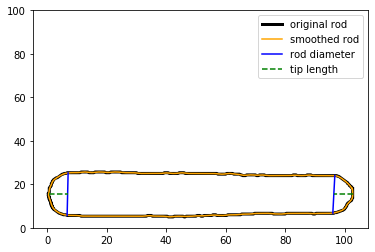

tip to diameter ratios, right tip =  0.368 left tip =  0.33
total rod area =  2211.885 tip area =  366.48 percentage area tip =  0.166


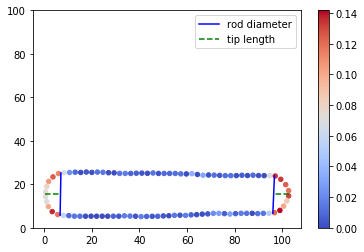

average curvature right =  0.121 average curvature left =  0.1 units (nm^-1)
1


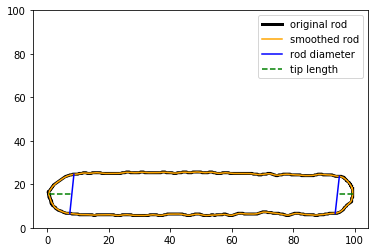

tip to diameter ratios, right tip =  0.296 left tip =  0.415
total rod area =  2070.821 tip area =  344.154 percentage area tip =  0.166


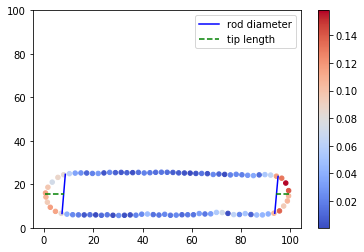

average curvature right =  0.125 average curvature left =  0.099 units (nm^-1)
2


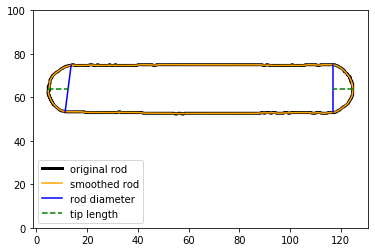

tip to diameter ratios, right tip =  0.35 left tip =  0.367
total rod area =  2875.053 tip area =  526.292 percentage area tip =  0.183


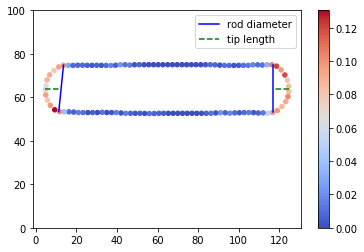

average curvature right =  0.097 average curvature left =  0.091 units (nm^-1)
3


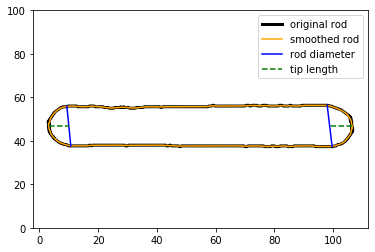

tip to diameter ratios, right tip =  0.411 left tip =  0.382
total rod area =  2112.254 tip area =  424.421 percentage area tip =  0.201


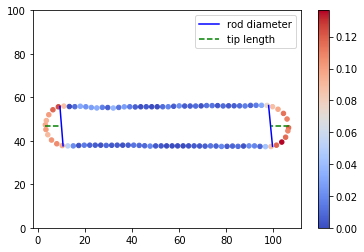

average curvature right =  0.109 average curvature left =  0.104 units (nm^-1)
4


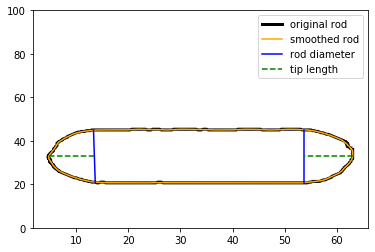

tip to diameter ratios, right tip =  0.383 left tip =  0.365
total rod area =  1676.986 tip area =  686.208 percentage area tip =  0.409


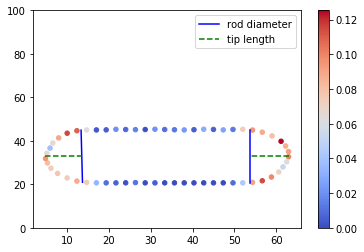

average curvature right =  0.089 average curvature left =  0.081 units (nm^-1)
5


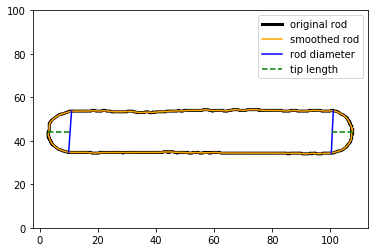

tip to diameter ratios, right tip =  0.36 left tip =  0.398
total rod area =  2269.173 tip area =  435.784 percentage area tip =  0.192


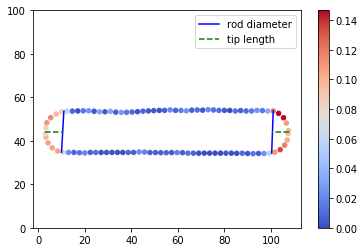

average curvature right =  0.118 average curvature left =  0.099 units (nm^-1)
6


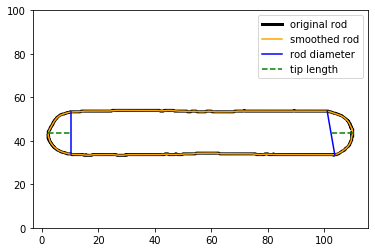

tip to diameter ratios, right tip =  0.385 left tip =  0.413
total rod area =  2384.59 tip area =  483.257 percentage area tip =  0.203


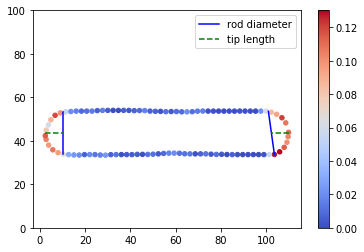

average curvature right =  0.112 average curvature left =  0.094 units (nm^-1)
7


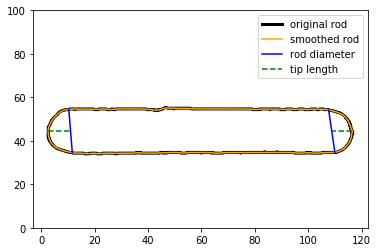

tip to diameter ratios, right tip =  0.395 left tip =  0.418
total rod area =  2560.269 tip area =  496.452 percentage area tip =  0.194


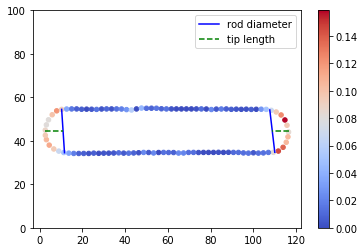

average curvature right =  0.114 average curvature left =  0.095 units (nm^-1)
8


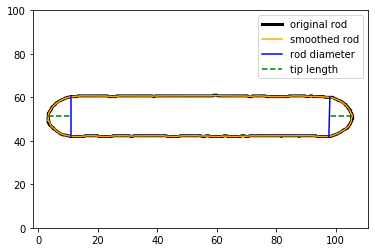

tip to diameter ratios, right tip =  0.428 left tip =  0.423
total rod area =  2072.787 tip area =  435.358 percentage area tip =  0.21


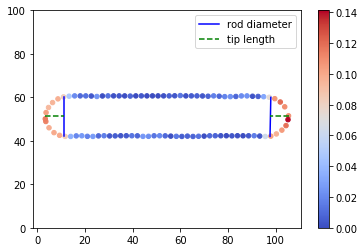

average curvature right =  0.112 average curvature left =  0.102 units (nm^-1)
9


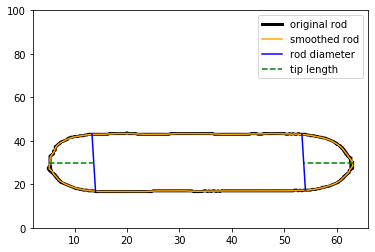

tip to diameter ratios, right tip =  0.363 left tip =  0.324
total rod area =  1793.638 tip area =  725.067 percentage area tip =  0.404


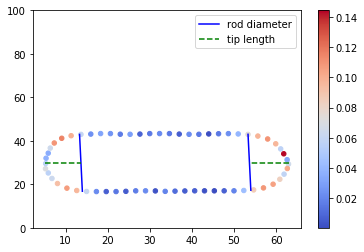

average curvature right =  0.089 average curvature left =  0.076 units (nm^-1)
10


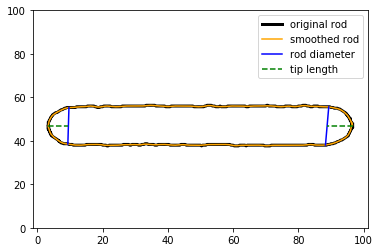

tip to diameter ratios, right tip =  0.446 left tip =  0.368
total rod area =  1853.206 tip area =  376.095 percentage area tip =  0.203


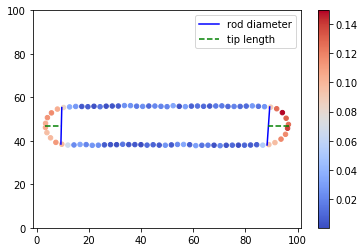

average curvature right =  0.119 average curvature left =  0.106 units (nm^-1)
11


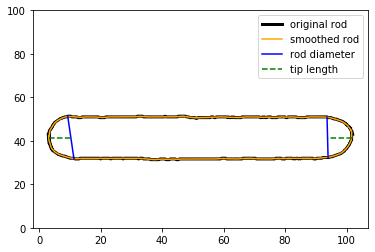

tip to diameter ratios, right tip =  0.428 left tip =  0.372
total rod area =  2116.5 tip area =  446.5 percentage area tip =  0.211


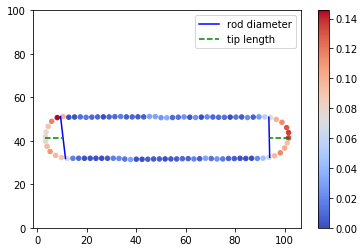

average curvature right =  0.11 average curvature left =  0.098 units (nm^-1)
12


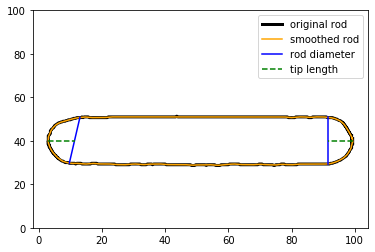

tip to diameter ratios, right tip =  0.359 left tip =  0.399
total rod area =  2320.841 tip area =  530.555 percentage area tip =  0.229


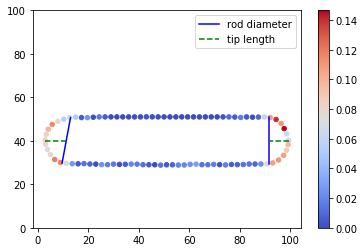

average curvature right =  0.104 average curvature left =  0.089 units (nm^-1)
13


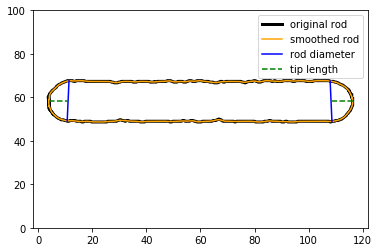

tip to diameter ratios, right tip =  0.431 left tip =  0.388
total rod area =  2289.477 tip area =  440.144 percentage area tip =  0.192


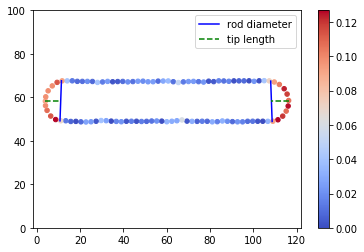

average curvature right =  0.112 average curvature left =  0.105 units (nm^-1)
14


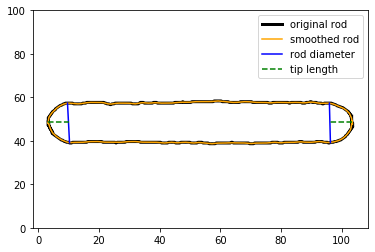

tip to diameter ratios, right tip =  0.412 left tip =  0.368
total rod area =  2095.148 tip area =  400.536 percentage area tip =  0.191


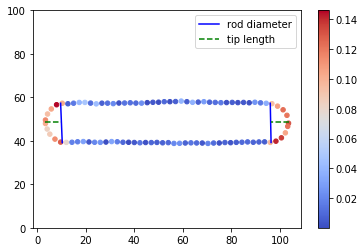

average curvature right =  0.12 average curvature left =  0.108 units (nm^-1)
15


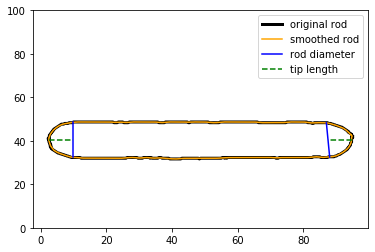

tip to diameter ratios, right tip =  0.467 left tip =  0.463
total rod area =  1686.956 tip area =  369.456 percentage area tip =  0.219


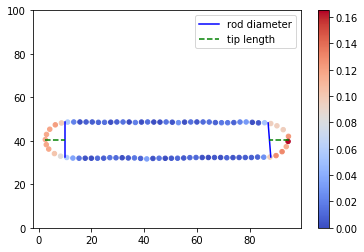

average curvature right =  0.117 average curvature left =  0.11 units (nm^-1)
16


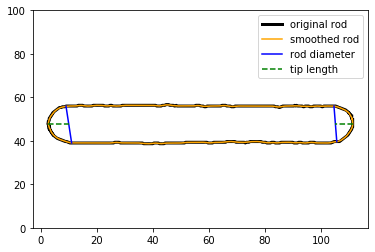

tip to diameter ratios, right tip =  0.379 left tip =  0.433
total rod area =  2049.532 tip area =  350.127 percentage area tip =  0.171


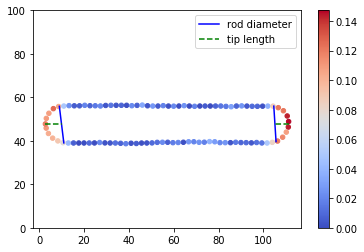

average curvature right =  0.128 average curvature left =  0.108 units (nm^-1)
17


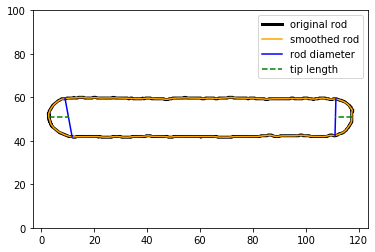

tip to diameter ratios, right tip =  0.376 left tip =  0.425
total rod area =  2221.089 tip area =  372.478 percentage area tip =  0.168


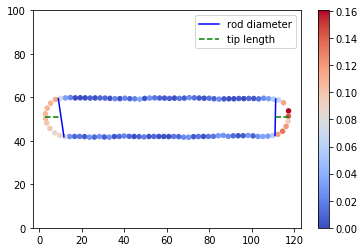

average curvature right =  0.119 average curvature left =  0.1 units (nm^-1)
18


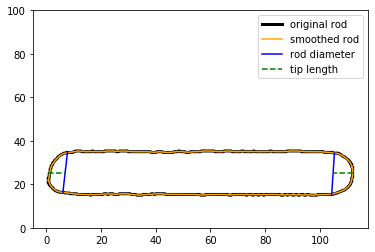

tip to diameter ratios, right tip =  0.377 left tip =  0.336
total rod area =  2384.144 tip area =  391.477 percentage area tip =  0.164


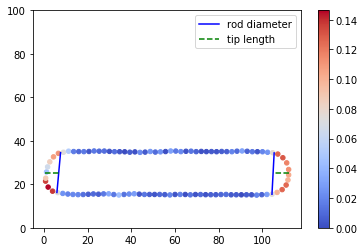

average curvature right =  0.116 average curvature left =  0.1 units (nm^-1)
19


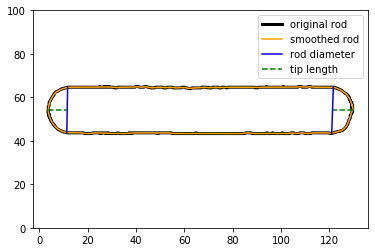

tip to diameter ratios, right tip =  0.396 left tip =  0.378
total rod area =  2894.425 tip area =  530.393 percentage area tip =  0.183


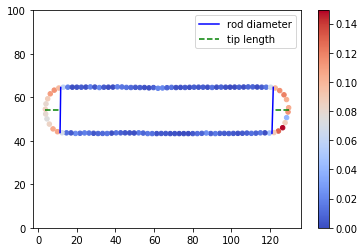

average curvature right =  0.105 average curvature left =  0.094 units (nm^-1)


In [42]:
for i in range(0,20):
    print(i)
    image = data['particles_plot'][0][i]
    rotated = ndimage.rotate(image, 360-data['orientation_plot'][0][i][0][0])
    ratio_extracted = determine_tip_and_curvature(rotated, pixel_to_nm_ratio = 3)